In [20]:
%load_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
%autoreload 2

In [22]:
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime
''' Sn properties - Masses, Ratios, Cup Configurations, ... '''
from sn_config import *
'''Classes for Reading in the Data and applying Internal Normalisation'''
from nu_data_reduction import NU_data_read, int_norm, evaluation
from pylab import plot, show, savefig
from scipy import stats
#%pylab inline

In [38]:
path = "/Volumes/friebelm/PhD/NU Plasma/Measurements/2015-11-11/"
path_sav = "/Volumes/friebelm/PhD/NU Plasma/Measurements/compilation/"
files_start = 2774
files_end = 2967

In [39]:
# cup configuration
cup_config = cycle_Sb_2
# Isotopes used for Interference correction
corr_isotopes_1 = {"Cd" : "111", "Te" : "125"}
corr_isotopes_2 = {"Cd" : "111","Te" : "125", "Xe" : "129"}
corr_isotopes_Sb = {"Te": "125", "Xe" : "129"}
#
# Mass Range of cup configuration
mass_range = cycle_Sb_2_mass_range
#isotopes = [["111", "112", "114", "115", "116", "117", "118", "119", "122", "124", "125", "126", "129"], ["117", "118", "119", "122", "124"]]
#isotopes = [["112", "114", "115", "116", "117", "118", "119", "122", "124"]]
isotopes = [["116", "117", "119", "120", "122", "124"]]
data_sample_column = [(i + "/" + "118") for i in isotopes[0]]

#number of iterations for beta
iter_beta = 10

# Interference_corr on the denominator isotope
isotope_denom_corr = False

blk_corr = False

In [40]:
columns = ["cycle", "sample", "date", "H8 (1)", "H7 (1)", "H6 (1)", "H5 (1)", "H4 (1)", "H3 (1)", "H2 (1)", "H1 (1)", "Ax (1)", "L1 (1)", "L2 (1)", "L3 (1)"]
blk_ls = []
sample_ls = []
df_all = pd.DataFrame()
files_1 = range(files_start, files_end, 1)
for sample in files_1:
    df = NU_data_read(path, sample, cup_config)
    cycles = range(1, len(df.data_read(sample).index)+1)
    df_zero = df.data_zero_corr(sample)
    df_zero = pd.DataFrame(df_zero["cycle1"])
    sample_name = df.extract_metadata(sample, "Sample Name")
    date = df.extract_metadata(sample, "Date")
    starttime = df.extract_metadata(sample, "Start Time")
    df_zero["date"] = datetime.strptime(date+starttime, '%d/%m/%Y%H:%M')
    df_zero["sample"] = sample_name
    df_zero["cycle"] = df_zero.index.values
    df_zero.index = df_zero["date"]
    df_zero = df_zero[columns]
    df_all = df_all.append(df_zero, ignore_index = True)

    if sample_name == "blank sol" or sample_name == "wash" or sample_name == "wash clean":
        blk_ls.append(sample)
    elif sample_name == "SQ" or sample_name == "teflon blank":
        None
    else:
        sample_ls.append(sample)

df_all.set_index("date", inplace = True)
df_all

,cycle,sample,H8 (1),H7 (1),H6 (1),H5 (1),H4 (1),H3 (1),H2 (1),H1 (1),Ax (1),L1 (1),L2 (1),L3 (1)
date,,,,,,,,,,,,,,
2015-11-11 14:24:00,1,NIST 100ppb,0.011149,0.036789,-2.965000e-06,1.908654,4.274172,1.489003,5.569537,10.214060,2.656132,7.392336,2.310477,4.321014
2015-11-11 14:24:00,2,NIST 100ppb,0.011189,0.036810,-1.000820e-05,1.887074,4.225897,1.472325,5.506322,10.098335,2.626300,7.308891,2.284440,4.272100
2015-11-11 14:24:00,3,NIST 100ppb,0.011194,0.036765,8.975200e-06,1.902306,4.259167,1.484232,5.549778,10.180525,2.647672,7.368391,2.303076,4.306966
2015-11-11 14:24:00,4,NIST 100ppb,0.011190,0.036681,-1.861310e-05,1.869606,4.184788,1.458554,5.452889,10.005258,2.602126,7.241644,2.263363,4.233132
2015-11-11 14:24:00,5,NIST 100ppb,0.011235,0.036719,-1.566450e-05,1.874539,4.194877,1.462511,5.466193,10.031787,2.608953,7.260588,2.269512,4.244176
2015-11-11 14:24:00,6,NIST 100ppb,0.011230,0.036689,-5.922500e-06,1.891331,4.231311,1.475533,5.513701,10.121556,2.632037,7.325113,2.289590,4.282004
2015-11-11 14:24:00,7,NIST 100ppb,0.011207,0.036600,-3.612200e-06,1.882057,4.210197,1.468287,5.485549,10.070750,2.619159,7.288702,2.278095,4.260428
2015-11-11 14:24:00,8,NIST 100ppb,0.011243,0.036556,-2.166250e-05,1.868629,4.178509,1.457897,5.444847,9.999651,2.600635,7.237506,2.262205,4.230687
2015-11-11 14:24:00,9,NIST 100ppb,0.011260,0.036511,-4.063400e-06,1.868138,4.176008,1.457461,5.441265,9.996504,2.599928,7.235404,2.261572,4.229367


In [58]:
df_all[df_all["L1 (1)"].std() < 1]

KeyError: False

In [49]:
files_1 = range(files_start, files_end, 1)
df_raw_signals = pd.DataFrame()
df_external_norm = pd.DataFrame()
df_external_norm_mean = pd.DataFrame()
df_external_outlier = pd.DataFrame()

for sample in sample_ls:
    df = NU_data_read(path, sample, cup_config)
    cycles = range(1, len(df.data_read(sample).index)+1)
    # arbitrary blank positions
    #blk1 = [item for item in blk_ls if item < sample]
    #blk2 = [item for item in blk_ls if item > sample]
    #blk1 = blk1[-1]
    #blk2 = blk2[0]
    #blk_corr_sample == True
    
    # blank measurement surrounds sample
    #if ((sample-1) in blk_ls) and ((sample+1) in blk_ls):
    #    blk1 = sample-1
    #    blk2 = sample+1
    #    blk_corr_sample = True
    #else:
    #    blk_corr_sample = False
    
    if (blk_corr == True) and (blk_corr_sample == True):
        blk_1 = NU_data_read(path, blk1, cup_config)
        blk_2 = NU_data_read(path, blk2, cup_config)
        df_zero = df.data_zero_corr(sample)
        df_bgd_1 = blk_1.data_zero_corr(blk1)
        df_bgd_2 = blk_2.data_zero_corr(blk2)
        new_corr = evaluation(df_zero, cycles, isotopes, cup_config, database, mass_range, corr_isotopes_Sb , denom_corr_ratio)
        new_corr.data_bgd_corr(df_bgd_1, df_bgd_2)
    else:
        df_zero = df.data_zero_corr(sample)
        new_corr = evaluation(df_zero, cycles, isotopes, cup_config, database, mass_range, corr_isotopes_Sb , denom_corr_ratio)
    
    data_sample_raw = new_corr.raw_signals("118")
    data_sample_raw = pd.DataFrame.from_dict(data_sample_raw, orient = 'index')
    data_sample_raw = data_sample_raw[np.abs(data_sample_raw-data_sample_raw.mean())<=(2*data_sample_raw.std())]
    
    data_sample = new_corr.internal_norm_1("118", 10)
    data_sample = pd.DataFrame.from_dict(data_sample, orient = 'index')
    data_sample = data_sample[np.abs(data_sample-data_sample.mean())<=(2*data_sample.std())]
    data_sample_outlier= data_sample[np.abs(data_sample-data_sample.mean())>(2*data_sample.std())]
    
    sample_name = df.extract_metadata(sample, "Sample Name")
    date = df.extract_metadata(sample, "Date")
    starttime = df.extract_metadata(sample, "Start Time")
    data_sample = data_sample[["116", "117", "119", "120", "122", "124"]]
    data_sample.columns = ["116/118", "117/118", "119/118", "120/118", "122/118", "124/118"]
    data_sample["date"] = datetime.strptime(date+starttime, '%d/%m/%Y%H:%M')
    data_sample["sample"] = sample_name
    data_sample["cycle"] = data_sample.index.values
    data_sample_outlier = data_sample_outlier[["116", "117", "119", "120", "122", "124"]]
    data_sample_outlier.columns = ["116/118", "117/118", "119/118", "120/118", "122/118", "124/118"]
    data_sample_outlier["date"] = datetime.strptime(date+starttime, '%d/%m/%Y%H:%M')
    data_sample_outlier["sample"] = sample_name
    data_sample_outlier["cycle"] = data_sample.index.values
    
    
    data_sample_raw["cycle"] = data_sample_raw.index.values
    data_sample = data_sample.merge(data_sample_raw)
    
    df_external_norm = df_external_norm.append(data_sample)
    df_external_outlier = df_external_outlier.append(data_sample_outlier) 

In [53]:
#df_external_norm.set_index("date", inplace = True)
columns = ["cycle", "sample"]
columns.extend(data_sample_column)
columns.extend(sorted(data_sample_raw.drop("cycle", axis=1).columns))
df_external_sub = pd.DataFrame(df_external_norm, columns = columns)

df_all_sub = df_all[(df_all["sample"] != "blank sol") & (df_all["sample"] != "teflon blank")]
df_external_sub["125"] = df_all_sub["H6 (1)"]
df_external_sub["Te/Sn"] = (df_all_sub["H6 (1)"]/7.0509)/(df_all_sub["L1 (1)"]/24.223)

#df_external_sub = df_external_sub[df_external_sub["118"] > 4]
df_external_sub

,cycle,sample,116/118,117/118,119/118,120/118,122/118,124/118,116,117,118,119,120,122,124,125,Te/Sn
date,,,,,,,,,,,,,,,,,
2015-11-11 14:24:00,1,NIST 100ppb,0.600265,0.316707,0.354619,1.346070,0.19125,0.239027,4.321014,2.310477,7.392336,2.656132,10.214060,1.489003,1.908654,-2.965000e-06,-1.377928e-06
2015-11-11 14:24:00,2,NIST 100ppb,0.600273,0.316720,0.354631,1.345952,0.19125,0.238991,4.272100,2.284440,7.308891,2.626300,10.098335,1.472325,1.887074,-1.000820e-05,-4.704223e-06
2015-11-11 14:24:00,3,NIST 100ppb,0.600268,0.316721,0.354635,1.345989,0.19125,0.238993,4.306966,2.303076,7.368391,2.647672,10.180525,1.484232,1.902306,8.975200e-06,4.184609e-06
2015-11-11 14:24:00,4,NIST 100ppb,0.600274,NaN,0.354643,1.346033,0.19125,0.239032,4.233132,2.263363,7.241644,2.602126,10.005258,1.458554,1.869606,-1.861310e-05,-8.830086e-06
2015-11-11 14:24:00,5,NIST 100ppb,0.600300,0.316739,0.354637,1.346016,0.19125,0.239003,4.244176,2.269512,7.260588,2.608953,10.031787,1.462511,1.874539,-1.566450e-05,-7.411876e-06
2015-11-11 14:24:00,6,NIST 100ppb,0.600320,0.316728,0.354622,1.346088,0.19125,0.239014,4.282004,2.289590,7.325113,2.632037,10.121556,1.475533,1.891331,-5.922500e-06,-2.777628e-06
2015-11-11 14:24:00,7,NIST 100ppb,0.600297,0.316717,0.354645,1.345981,0.19125,0.239009,4.260428,2.278095,7.288702,2.619159,10.070750,1.468287,1.882057,-3.612200e-06,-1.702570e-06
2015-11-11 14:24:00,8,NIST 100ppb,0.600308,0.316728,0.354632,1.345965,0.19125,0.239001,4.230687,2.262205,7.237506,2.600635,9.999651,1.457897,1.868629,-2.166250e-05,-1.028260e-05
2015-11-11 14:24:00,9,NIST 100ppb,0.600291,0.316731,0.354639,1.345941,0.19125,0.239010,4.229367,2.261572,7.235404,2.599928,9.996504,1.457461,1.868138,-4.063400e-06,-1.929346e-06


In [60]:
def SE(x):
    SE = np.std(x) / x.count()
    return SE

df_external_norm_mean = df_external_sub.drop("cycle", axis=1).groupby(df_external_sub.index).mean()
df_external_norm_mean_sd = df_external_sub.drop("cycle", axis=1).groupby(df_external_sub.index).agg([np.mean, SE])
df_external_norm_mean["sample"] = df_external_norm[df_external_norm["cycle"] == 1]["sample"]
df_external_norm_mean_sd["sample"] = df_external_norm[df_external_norm["cycle"] == 1]["sample"]

#df_external_norm_mean = df_external_norm_mean[1:]
#df_external_norm_mean = df_external_norm_mean.drop(datetime.strptime("20150310 23:59", "%Y%m%d %H:%M"))
#df_external_norm_mean_sd = df_external_norm_mean_sd[1:]
df_external_norm_mean

,116/118,117/118,119/118,120/118,122/118,124/118,116,117,118,119,120,122,124,125,Te/Sn,sample
date,,,,,,,,,,,,,,,,
2015-11-11 14:24:00,0.600288,0.316724,0.354631,1.345999,0.19125,0.239007,4.254758,2.275099,7.278808,2.615456,10.056934,1.466190,1.879287,-5.954465e-06,-2.827424e-06,NIST 100ppb
2015-11-11 14:33:00,0.600275,0.316724,0.354639,1.346010,0.19125,0.239014,4.320595,2.310342,7.391665,2.656076,10.213084,1.488959,1.908552,2.256045e-06,1.033314e-06,NIST 100ppb
2015-11-11 14:41:00,0.600278,0.316724,0.354637,1.346015,0.19125,0.239000,4.329039,2.314656,7.404793,2.660549,10.229353,1.491083,1.910853,6.916475e-06,3.222479e-06,NIST 100ppb
2015-11-11 14:50:00,0.600287,0.316725,0.354638,1.346011,0.19125,0.239007,4.247461,2.271036,7.265124,2.610363,10.036375,1.462945,1.874813,-2.084400e-06,-1.000624e-06,NIST 100ppb
2015-11-11 14:59:00,0.600290,0.316730,0.354638,1.346011,0.19125,0.239004,4.356298,2.329290,7.451405,2.677312,10.293920,1.500511,1.922997,8.350795e-06,3.855143e-06,NIST 100ppb
2015-11-11 15:14:00,0.600274,0.316725,0.354640,1.346021,0.19125,0.239012,3.870929,2.069739,6.621279,2.379091,9.147224,1.333356,1.708806,-1.557130e-06,-8.714771e-07,NIST 100ppb
2015-11-11 15:23:00,0.600286,0.316728,0.354638,1.346023,0.19125,0.239007,4.401246,2.353315,7.528429,2.705036,10.400494,1.516077,1.942989,-1.620670e-06,-7.374612e-07,NIST 100ppb
2015-11-11 15:31:00,0.600286,0.316729,0.354643,1.346019,0.19125,0.239005,4.301319,2.299896,7.357501,2.643632,10.164339,1.481656,1.898863,6.462925e-06,3.027288e-06,NIST 100ppb
2015-11-11 15:40:00,0.600298,0.316729,0.354641,1.346004,0.19125,0.239004,4.117066,2.198939,7.036239,2.528083,9.730794,1.416730,1.816256,-3.826615e-06,-1.802892e-06,NIST 100ppb


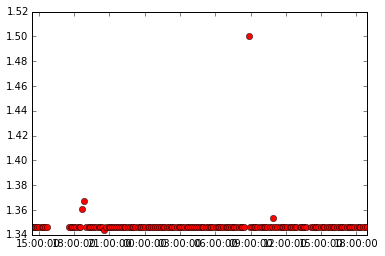

In [61]:
plot_Nist = df_external_norm_mean[df_external_norm_mean["sample"] == "NIST 100ppb"]
plot_Nist = df_external_norm_mean[(df_external_norm_mean["118"] >=1)]
#dataplot = plot(plot_Nist["Te/Sn"], plot_Nist["124/120"], "ro")
dataplot = plot(plot_Nist.index, plot_Nist["120/118"], "ro")
show(dataplot)

In [104]:
sub_index = df_external_norm_mean[(df_external_norm_mean["sample"].shift(1) == df_external_norm_mean["sample"].shift(-1)) & (df_external_norm_mean["sample"].shift(1) == "NIST 100ppb")].index
sample = df_external_norm_mean["sample"]
new = df_external_norm_mean[df_external_norm_mean.columns[df_external_norm_mean.dtypes != 'object']]

new =  ((new / ((new.shift(1) + new.shift(-1))/2))-1)*10000
new["sample"] = sample

new = new[new.index.isin(sub_index)]
#df_external_norm_signal = df_external_norm_signal[df_external_norm_signal['sample'].isin(sub_index.tolist())]
#df_new_signal = new.merge(df_external_norm_signal, left_index=True, right_index=True)
#new[new.sample != "NIST 100ppb"]
new

,116/118,117/118,119/118,120/118,122/118,124/118,116,117,118,119,120,122,124,sample
date,,,,,,,,,,,,,,
2015-11-03 13:03:00,0.062454,0.113392,0.016793,0.054813,0.000000e+00,0.095612,353.590468,353.697226,353.686973,353.822778,353.964608,354.056887,354.289130,NIST 100ppb
2015-11-03 13:12:00,0.102065,0.101421,-0.040106,-0.086259,0.000000e+00,-0.174225,-288.523735,-288.508116,-288.487926,-288.497673,-288.430273,-288.235129,-288.206196,NIST 100ppb
2015-11-03 13:20:00,0.172804,0.043419,0.084338,0.034722,0.000000e+00,-0.192873,87.999257,88.157374,88.159628,88.459618,88.366350,88.631675,88.713291,NIST 100ppb
2015-11-03 13:29:00,-0.283986,-0.100788,-0.040864,0.046303,2.220446e-12,0.488913,152.507783,152.441440,152.497881,152.252295,152.411512,152.118248,152.303217,NIST 100ppb
2015-11-03 13:38:00,0.259696,0.149089,0.011764,-0.098886,0.000000e+00,-0.528997,-166.464965,-166.404763,-166.409665,-166.207270,-166.246927,-165.871905,-166.050468,NIST 100ppb
2015-11-03 13:53:00,-0.134894,-0.186826,0.044047,-0.006143,0.000000e+00,0.180980,26.568048,26.274052,26.180249,25.992597,25.694062,25.208455,24.895045,NIST 100ppb
2015-11-03 14:02:00,0.050065,0.123371,-0.030800,0.081860,0.000000e+00,0.126282,-105.644328,-105.256548,-105.162754,-105.048779,-104.666144,-104.263247,-103.735038,NIST 100ppb
2015-11-03 14:10:00,-0.109781,-0.059695,-0.009887,-0.033614,0.000000e+00,-0.163622,251.122644,250.920716,250.949085,250.946357,250.767301,250.639067,250.372120,NIST 100ppb
2015-11-03 14:19:00,0.057977,0.060711,-0.030706,0.018988,0.000000e+00,0.174086,-203.179482,-198.261423,-203.095653,-203.102658,-203.013164,-203.048951,-202.882378,NIST 100ppb


In [105]:
def SD2(x):
    SD2 = np.std(x) * 2
    return SD2

#new = new.drop(["116", "117", "118", "119", "120", "122", "124"], axis=1)
np.round(new.groupby("sample").agg([np.mean, SD2]), decimals=2)

116/118       117/118       119/118       120/118  \
                            mean   SD2    mean   SD2    mean   SD2    mean   
sample                                                                       
BHVO-2 1_2(2) 1             0.02  0.00   -0.20  0.00   -0.19  0.00   -0.05   
BHVO-2 1_2(2) 2             0.02  0.00   -0.07  0.00   -0.02  0.00    0.00   
BHVO-2 1_2(2) 3            -0.07  0.00   -0.17  0.00   -0.25  0.00    0.08   
BHVO-2 2_1                  0.08  0.00    0.02  0.00   -0.10  0.00    0.20   
DTS-2B 1_1 1                0.24  0.00   -0.26  0.00    0.18  0.00    0.01   
DTS-2B 1_1 2               -0.30  0.00   -0.27  0.00    0.19  0.00    0.06   
DTS-2B 1_1 3               -0.06  0.00   -0.19  0.00    0.12  0.00   -0.22   
J2 1_1                     -0.07  0.00   -0.28  0.00   -0.08  0.00   -0.04   
J2 1_1 2                   -0.12  0.00   -0.15  0.00   -0.25  0.00   -0.19   
J2 2_1(1) 1                 0.16  0.00   -0.16  0.00    0.09  0.00    0.09   
J2 2_1(1) 2                 0.06  0.00   -0.16  0.00   -0.14  0.00    0.01   
J2 2_1(1) 3                 0.24  0.00    0.12  0.00    0.07  0.00    0.04   
NIST 100ppb                 0.00  0.27   -0.00  0.28   -0.00  0.21   -0.00   
NIST 100ppb + 0.005ppb U   -0.02  0.04    0.03  0.12    0.30  0.35    0.02   
NIST 100ppb + 0.03ppb U    -0.13  0.00   -0.11  0.00    1.43  0.00   -0.07   
NIST 2_1 1                  0.08  0.00    0.03  0.00    0.12  0.00   -0.01   
NIST 2_1 2                  0.12  0.00   -0.07  0.00    0.06  0.00    0.11   
NIST 2_1 3                  0.22  0.00    0.01  0.00    0.06  0.00    0.02   
NIST Ag1x8 1                0.02  0.00    0.02  0.00    0.04  0.00    0.24   
NIST Ag1x8 2               -0.18  0.00   -0.03  0.00    0.07  0.00   -0.12   
NIST Ag1x8 3               -0.21  0.00   -0.28  0.00   -0.08  0.00   -0.20   
NIST EV HCl 3              -0.05  0.00    0.01  0.00    0.14  0.00    0.02   
NIST EV HCl 3 2            -0.33  0.00   -0.09  0.00   -0.05  0.00   -0.06   
NIST EV HCl 6               0.03  0.00   -0.05  0.00   -0.09  0.00   -0.02   
NIST EV HCl 6 2             0.08  0.00    0.12  0.00    0.12  0.00   -0.02   
NIST EV HCl 7              -0.03  0.00    0.04  0.00    0.11  0.00   -0.02   
NIST EV HCl 7 2            30.98  0.00   64.41  0.00    1.55  0.00   92.64   
NIST EV NO3-HF 3            0.15  0.00   -0.01  0.00   -0.10  0.00    0.10   
NIST EV NO3-HF 3 2         -0.03  0.00    0.05  0.00    0.05  0.00   -0.12   
SPEX 100ppb                -0.03  0.32   -0.10  0.26   -0.05  0.17   -0.03   
ZH09-05 10.3(1) 1          -0.12  0.00   -0.33  0.00   -0.18  0.00   -0.07   
ZH09-05 10.3(1) 2           0.09  0.00   -0.28  0.00   -0.18  0.00   -0.14   
ZH09-05 10.3(1) 3           0.05  0.00   -0.10  0.00   -0.17  0.00   -0.21   
ZH09-05 23.3(1) 1           2.07  0.00   -0.27  0.00   -0.02  0.00    0.22   
ZH09-05 23.3(1) 2           1.85  0.00   -0.25  0.00   -0.05  0.00   -0.08   
ZH09-05 23.3(1) 3           1.89  0.00   -0.15  0.00   -0.17  0.00   -0.02   

                               122/118       ...        118              119  \
                           SD2    mean SD2   ...       mean     SD2     mean   
sample                                       ...                               
BHVO-2 1_2(2) 1           0.00       0   0   ...   -1808.81    0.00 -1808.85   
BHVO-2 1_2(2) 2           0.00       0   0   ...    1175.62    0.00  1176.08   
BHVO-2 1_2(2) 3           0.00       0   0   ...    2203.11    0.00  2202.87   
BHVO-2 2_1                0.00      -0   0   ...    -486.96    0.00  -486.06   
DTS-2B 1_1 1              0.00       0   0   ...   -1587.29    0.00 -1586.05   
DTS-2B 1_1 2              0.00       0   0   ...     856.39    0.00   857.18   
DTS-2B 1_1 3              0.00       0   0   ...    1750.14    0.00  1751.35   
J2 1_1                    0.00       0   0   ...     166.84    0.00   167.63   
J2 1_1 2                  0.00       0   0   ...    2584.57    0.00  2585.29   
J2 2_1(1) 1           

In [50]:
df_all.to_csv(path_sav + "Sn_H6_L3_Sb_NU_Signals_zero_corr.csv", mode='a', header=False)

In [100]:
df_external_sub.to_csv(path_sav + "Sn_H6_L3_SB_external_norm.csv", mode='a', header=False)

In [114]:
df_external_norm_mean_sd.to_csv(path + "Sn_H8_L3_SB_internal_norm_mean_122_118.csv", mode='a', header=True)